In [1]:
import pandas as pd 
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings 
warnings.filterwarnings('ignore')

In [3]:
crime = pd.read_hdf("/Users/evandimartinis/Downloads/crime.h5")
crime=crime.set_index('REPORTED_DATE')
crime=crime.sort_index()
mnthly_crimes = crime.resample('M').sum()
mnthly_traffic=mnthly_crimes[['IS_TRAFFIC']]
mnthly_traffic.head()

,IS_TRAFFIC
REPORTED_DATE,
2012-01-31,1569
2012-02-29,1629
2012-03-31,1528
2012-04-30,1595
2012-05-31,1831


### Running the Dickey fuller test for stationarity

In [12]:
y=mnthly_crimes['IS_CRIME']
result=adfuller(y)

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])


ADF Statistic: -2.882866
p-value: 0.047377


### ARIMA MODELING

### Finding the value of p,d,q

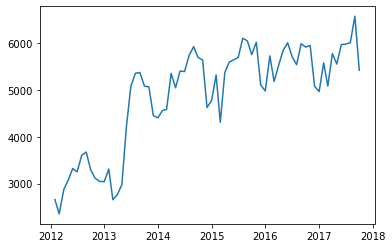

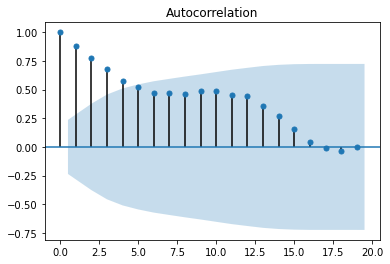

In [13]:
#Plotting the original series and its autocorrelation plot
plt.plot(y)
plot_acf(y);

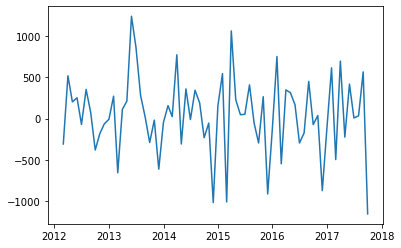

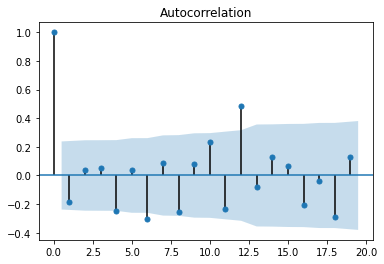

In [14]:
#Plotting the 1st differencing of the series and its autocorrelation plot
plt.plot(y.diff())
plot_acf(y.diff().dropna());

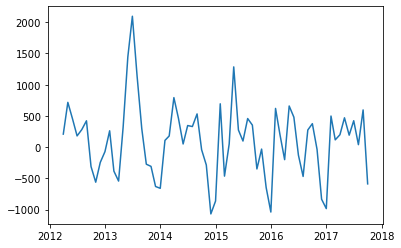

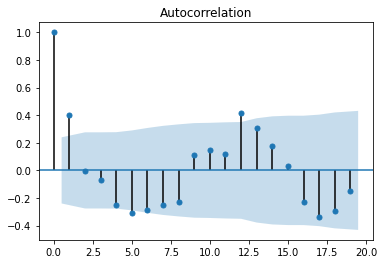

In [15]:
#Plotting the 2nd differencing of the series and its autocorrelation plot
plt.plot(y.diff(2))
plot_acf(y.diff(2).dropna());

In [16]:
#ADfuller test after 1st differencing

result=adfuller(y.diff().dropna())

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -2.184494
p-value: 0.211921


### Partial autocorrelation to find p

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

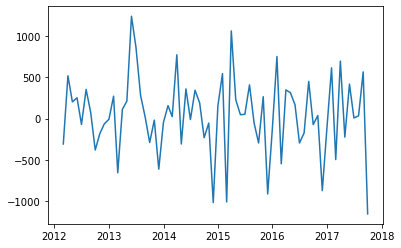

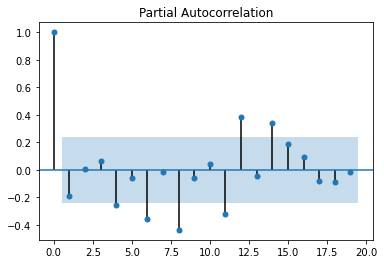

In [17]:
#Plotting the 1st differencing of the series and its autocorrelation plot
plt.plot(y.diff())
plot_pacf(y.diff().dropna());

In [18]:
from statsmodels.tsa.arima_model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(y, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.IS_CRIME   No. Observations:                   68
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -513.306
Method:                       css-mle   S.D. of innovations            459.104
Date:                Thu, 29 Apr 2021   AIC                           1036.613
Time:                        12:35:03   BIC                           1047.710
Sample:                    02-29-2012   HQIC                          1041.010
                         - 09-30-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               44.0533     49.969      0.882      0.378     -53.884     141.991
ar.L1.D.IS_CRIME    -0.0720      0.564     -0.128      0.898      -1.176       1.032
ma.L1.D.IS_CRIME    -0.1300 

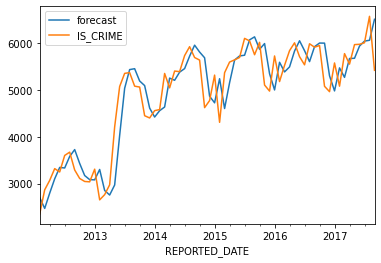

In [19]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

### Out-of-Time Cross validation

In [20]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = y[:59]
test = y[59:]

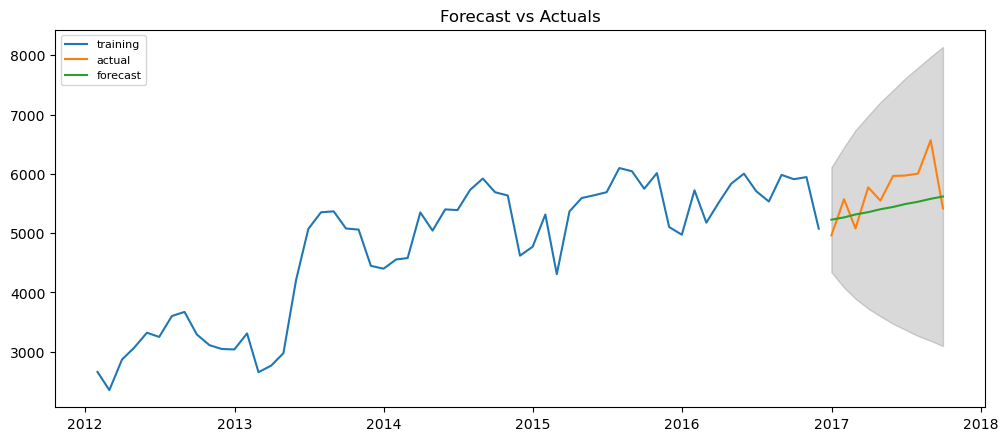

In [21]:
# Build Model
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [22]:
import numpy as np
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))
mape

0.06890582649901769